# Modelo de mezclas Gaussianas

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/7/71/Gaussian-mixture-example.svg" width="500px" height="300px" />

> El modelo de mezclas Gaussianas es un modelo de soft-clustering que nos permite modelar con precisión arbitraria un conjunto de datos continuos. Este poderoso algoritmo siempre conviene tenerlo en el arsenal para problemas de segmentación.

> **Objetivos:**
> - Comprender el modelo de mezclas Gaussianas.

> **Referencias:**
> - Bayesian Methods for Machine Learning course, HSE University, Coursera.

## 1. Introducción

Como vimos, el K-Means (y en general los algoritmos de hard clustering) tienen varios detalles:

- No es claro cómo elegir el número de clusters.
- Hay puntos que podrían estar en una frontera entre dos o más clusters, y el hard clustering no nos permite tener incertidumbre en la pertenencia.

Para lidiar con estos problemas, podemos plantear un modelo probablístico de nuestros datos.

Hasta ahora, conocemos algunas distribuciones. Entre ellas la Gaussiana, para la cual ya sabemos como estimar sus parámetros.

¿Qué pasa si intentamos ajustar una **distribución Gaussiana** a los datos? Es decir, si modelamos los datos con

$$
p(x|\theta) = \mathcal{N}(x|\mu, \Sigma), \qquad \theta=\{\mu, \Sigma\}
$$

In [1]:
# Importamos función para generar datos
from bank_customer_data import generate_bank_customer_data
# Importamos pyplot
from matplotlib import pyplot as plt

In [2]:
# Generamos datos
data = generate_bank_customer_data()

In [3]:
data.head(10)

,income,debt,labels
0,1.673119,6.334537,1.0
1,1.839070,2.175017,0.0
2,1.625623,5.942722,1.0
3,4.704266,2.414412,0.0
4,3.586849,1.827950,0.0
5,3.166081,3.625621,0.0
6,4.719589,2.077889,0.0
7,2.779686,3.147934,0.0
8,3.152437,3.422377,0.0
9,3.113990,3.540098,0.0


Text(0, 0.5, 'Deuda (x100k MXN)')

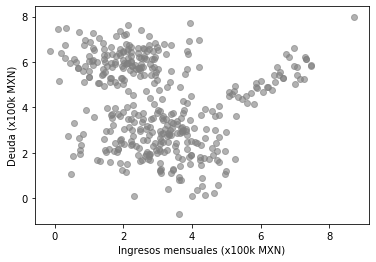

In [4]:
# Datos
plt.scatter(data["income"], data["debt"], c="gray", alpha=0.6)
plt.xlabel("Ingresos mensuales (x100k MXN)")
plt.ylabel("Deuda (x100k MXN)")

In [5]:
# scipy.stats.multivariate_normal
from scipy.stats import multivariate_normal

In [6]:
# Ajustamos parámetros
mu = data[["income", "debt"]].mean()
Sigma = data[["income", "debt"]].cov()
# Definimos VA
X = multivariate_normal(mean=mu,
                        cov=Sigma)

In [7]:
import numpy as np

Text(0, 0.5, 'Deuda (x100k MXN)')

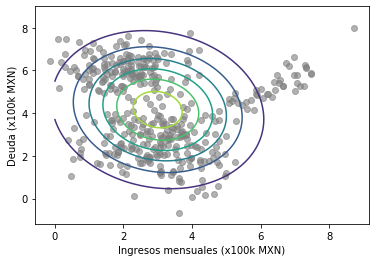

In [8]:
# Datos
plt.scatter(data["income"], data["debt"], c="gray", alpha=0.6)
# Gaussiana
x = np.linspace(0, 8, 100)
y = np.linspace(0, 9, 100)
x, y = np.meshgrid(x, y)
z = X.pdf(np.dstack([x, y]))
plt.contour(x, y, z)
plt.xlabel("Ingresos mensuales (x100k MXN)")
plt.ylabel("Deuda (x100k MXN)")

In [9]:
# Verosimilitud
X.pdf(data[["income", "debt"]]).prod()

0.0

In [10]:
# Log-verosimilitud
X.logpdf(data[["income", "debt"]]).sum()

-1573.3408056436479

Sin embargo, este modelo no parece corresponder con nuestros datos. La región de máxima probabilidad (media) cae en un punto medio entre los clusters, y allí no hay muchos datos.

### ¿Qué pasa si usamos varias Gaussianas?

In [11]:
# Ajustamos parámetros
mu1 = data.loc[data["labels"] == 0, ["income", "debt"]].mean()
mu2 = data.loc[data["labels"] == 1, ["income", "debt"]].mean()
mu3 = data.loc[data["labels"] == 2, ["income", "debt"]].mean()
cov1 = data.loc[data["labels"] == 0, ["income", "debt"]].cov()
cov2 = data.loc[data["labels"] == 1, ["income", "debt"]].cov()
cov3 = data.loc[data["labels"] == 2, ["income", "debt"]].cov()
# Definimos VA
X1 = multivariate_normal(mean=mu1, cov=cov1)
X2 = multivariate_normal(mean=mu2, cov=cov2)
X3 = multivariate_normal(mean=mu3, cov=cov3)

Text(0, 0.5, 'Deuda (x100k MXN)')

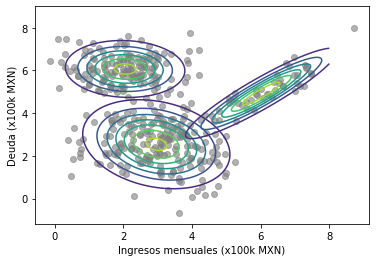

In [12]:
# Datos
plt.scatter(data["income"], data["debt"], c="gray", alpha=0.6)

# Gaussiana 1
x = np.linspace(0, 6, 100)
y = np.linspace(0, 5, 100)
x, y = np.meshgrid(x, y)
z = X1.pdf(np.dstack([x, y]))
plt.contour(x, y, z)

# Gaussiana 2
x = np.linspace(0, 4, 100)
y = np.linspace(4, 9, 100)
x, y = np.meshgrid(x, y)
z = X2.pdf(np.dstack([x, y]))
plt.contour(x, y, z)

# Gaussiana 3
x = np.linspace(3, 8, 100)
y = np.linspace(2, 8, 100)
x, y = np.meshgrid(x, y)
z = X3.pdf(np.dstack([x, y]))
plt.contour(x, y, z)

plt.xlabel("Ingresos mensuales (x100k MXN)")
plt.ylabel("Deuda (x100k MXN)")

**¡Mucho mejor!**

Cada Gaussiana explica un cluster de puntos, y el modelo general sería una suma ponderada de estas densidades Gaussianas:

$$
p(x | \theta) = \sum_{c=1}^{3} \pi_c \mathcal{N}(x | \mu_c, \Sigma_c), \qquad \theta = \{\pi_1, \pi_2, \pi_3, \mu_1, \mu_2, \mu_3, \Sigma_1, \Sigma_2, \Sigma_3\}
$$

**¿Y esto cómo lo interpretamos?**

Bueno, pues si logramos encontrar los parámetros $\pi_1, \pi_2, \pi_3, \mu_1, \mu_2, \mu_3, \Sigma_1, \Sigma_2, \Sigma_3$ para este conjunto de datos, habremos resuelto el problema de (soft) clustering, ya que encontraremos para cada punto la probabilidad de que venga de cada una de las Gaussianas.

**¿Qué ventajas tenemos?**

Como ventaja respecto a usar una sola Gaussiana, hemos añadido flexibilidad a nuestro modelo. Es decir, con esta estuctura podemos representar conjuntos de datos complejos.

> En efecto, podemos aproximar casi cualquier distribución continua con una mezcla de Gaussianas con precisión arbitraria, dado que incluyamos un número suficiente de Gaussianas en la mezcla.

**¿A qué costo?**

La cantidad de parámetros que debemos estimar se multiplica por la cantidad de Gaussianas en la mezcla.

### ¿Cómo encontramos (entrenamos) los parámetros?

Podemos maximizar la función de verosimilitud (suposición de independencia):

$$
\max_{\theta} p(X | \theta) = \prod_{i=1}^N p(x_i | \theta) = \prod_{i=1}^N \sum_{c=1}^{3} \pi_c \mathcal{N}(x_i | \mu_c, \Sigma_c)
$$

sujeto a:

\begin{align}
\sum_{c=1}^3 \pi_c & = 1 \\
\pi_c & \geq 0 \quad \text{for } c=1,2,3\\
\Sigma_c & \succ 0 \quad \text{for } c=1,2,3
\end{align}

Es decir, las matrices de covarianza deben ser definidas positivas (¿por qué?).

**Complejidades numéricas:**

Este problema de optimización puede ser resuelto numéricamente con un algoritmo como el gradiente descendiente. Sin embargo,

1. La restricción sobre la matriz de covarianzas hace el problema de optimización muy complejo de resolver numéricamente hablando.

   Una simplificación para poder trabajar con esta restricción es suponer que las matrices de covarianza son diagonales:

$$
\Sigma_c = \text{diag}(\sigma_{c1}, \sigma_{c2}, \dots, \sigma_{cn}),
$$

2. La suma dentro del producto también hace bastante complejo el cálculo de los gradientes. Comúnmente, para evitar el producto se toma logaritmo de la verosimilitud:

   $$
   \log p(X | \theta) = \log \left(\prod_{i=1}^N p(x_i | \theta) \right)= \sum_{i=1}^N \log\left(\sum_{c=1}^{3} \pi_c \mathcal{N}(x_i | \mu_c, \Sigma_c)\right)
   $$

   y con esto, podemos observar que permanece una suma ponderada dentro del logaritmo.

### ¿Y entonces?

Afortunadamente, existe un algoritmo alternativo con base probabilística llamado **algoritmo de maximización de la esperanza**, el cual estaremos estudiando en las próximas clases no solo para el problema de mezclas Gaussianas, sino para entrenar cualquier modelo con **variables latentes**.

**¿Variables latentes?**

Recordamos que propusimos el siguiente modelo:

$$
p(x | \theta) = \sum_{c=1}^{3} \pi_c \mathcal{N}(x | \mu_c, \Sigma_c), \qquad \theta = \{\pi_1, \pi_2, \pi_3, \mu_1, \mu_2, \mu_3, \Sigma_1, \Sigma_2, \Sigma_3\}
$$

Este modelo en realidad, lo podemos pensar como un modelo con una variable latente $t$ que determina a cuál Gaussiana pertenece cada punto:

![gmm](figures/gmm.png)

Entonces, razonablemente podemos atribuirle a $t$ tres posibles valores (1, 2, y 3), que nos dicen de qué Gaussiana viene el punto. Recordamos que $t$ es una variable latente, nunca la observamos.

Sin embargo, razonando probabilísticamente, después de entrenar nuestra mezcla Gaussiana, podríamos preguntarle al modelo, ¿Cuál es el valor más probable de $t$ dado el punto $x$? --> **Clustering**

Con este modelo, podemos asignar las siguientes probabilidades:

- Previa:
  
  $$
  p(t=c | \theta) = \pi_c
  $$
  
- Verosimilitud:
  
  $$
  p(x | t=c, \theta) = \mathcal{N}(x | \mu_c, \Sigma_c)
  $$
 
Razonable, ¿no?

Y con lo anterior,

$$
p(x | \theta) = \sum_{c=1}^3 p(x, t=c | \theta) = \sum_{c=1}^3 \underbrace{p(x | t=c, \theta)}_{\mathcal{N}(x | \mu_c, \Sigma_c)} \underbrace{p(t=c | \theta)}_{\pi_c},
$$

justo como el modelo intuitivo que habíamos propuesto.

## 2. Algoritmo de maximización de la esperanza para mezclas Gaussianas - Intuición

Supongamos que tenemos los siguientes puntos de tamaños de playeras, y queremos definir cuáles son talla chica y cuales son talla grande:

In [13]:
from shirts_size_data import generate_shirts_data
from scipy.stats.distributions import norm

In [14]:
shirts_data = generate_shirts_data()
shirts_data.head()

,size,labels
0,37.736419,1.0
1,30.255834,0.0
2,27.125678,0.0
3,40.940042,1.0
4,37.537882,1.0


Text(0.5, 0, 'Tamaño (cm)')

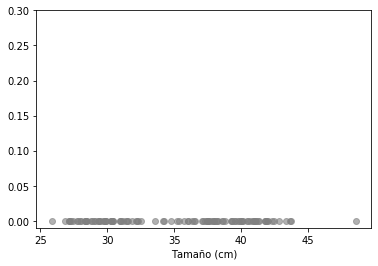

In [15]:
plt.scatter(shirts_data["size"], np.zeros(len(shirts_data)), c="gray", alpha=0.6)
plt.ylim([-0.01, 0.3])
plt.xlabel("Tamaño (cm)")

¿Cómo estimamos los parámetros de nuestro modelo de variable latente?

Analicemos varios casos:

1. Si de entrada supiéramos cuáles playeras son chicas y cuáles grandes:

Text(0.5, 0, 'Tamaño (cm)')

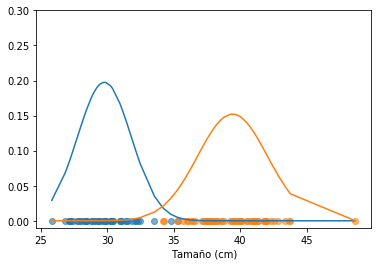

In [16]:
plt.scatter(shirts_data.loc[shirts_data["labels"] == 0, "size"],
            np.zeros((shirts_data["labels"] == 0).sum()),
            alpha=0.6)
plt.scatter(shirts_data.loc[shirts_data["labels"] == 1, "size"],
            np.zeros((shirts_data["labels"] == 1).sum()),
            alpha=0.6)
x = shirts_data["size"].copy().values
x.sort()
mu1 = shirts_data.loc[shirts_data["labels"] == 0, "size"].mean()
mu2 = shirts_data.loc[shirts_data["labels"] == 1, "size"].mean()
s1 = shirts_data.loc[shirts_data["labels"] == 0, "size"].std()
s2 = shirts_data.loc[shirts_data["labels"] == 1, "size"].std()
plt.plot(x, norm.pdf(x, loc=mu1, scale=s1))
plt.plot(x, norm.pdf(x, loc=mu2, scale=s2))
plt.ylim([-0.01, 0.3])
plt.xlabel("Tamaño (cm)")

$$
p(x | t=1, \theta) = \mathcal{N}(x | \mu_1, \sigma_1)
$$

Con lo cual:

$$
\mu_1 = \frac{\sum_{i: t_i = 1} x_i}{\sum_{i: t_i = 1} 1}, \qquad \sigma_1^2 = \frac{\sum_{i: t_i = 1} (x_i - \mu_1)^2}{\sum_{i: t_i = 1} 1},
$$

y

$$
\mu_2 = \frac{\sum_{i: t_i = 2} x_i}{\sum_{i: t_i = 2} 1}, \qquad \sigma_2^2 = \frac{\sum_{i: t_i = 2} (x_i - \mu_1)^2}{\sum_{i: t_2 = 1} 1}
$$

2. Como sablemos, en el algoritmo de mezclas Gaussianas nunca sabremos si un punto pertenece a cierto cluster o no, sino que conoceremos las probabilidades de que pertenezca a cada cluster.

   De modo que si conocemos la posterior $p(t | x, \theta)$, entonces ponderamos lo anterior por esta probabilidad:
   
   $$
\mu_1 = \frac{\sum_{i} p(t_i=1 | x_i, \theta)x_i}{\sum_{i} p(t_i=1 | x_i, \theta)}, \qquad \sigma_1^2 = \frac{\sum_{i} p(t_i=1 | x_i, \theta) (x_i - \mu_1)^2}{\sum_{i} p(t_i=1 | x_i, \theta)}.
   $$

3. ¿Y cómo conocemos la posterior $p(t | x, \theta)$?

   Bueno, pues si conocemos los parámetros, es bastante fácil:
   
   $$
   p(t=c | x, \theta) = \frac{p(x | t=c, \theta) p(t=c | \theta)}{Z} = \frac{\pi_c \mathcal{N}(x | \mu_c, \sigma_c)}{Z}.
   $$

Tenemos un razonamiento circular (un problema del tipo, ¿Qué fue primero?, ¿El huevo?, ¿O la gallina?). 

**¿Cómo lo resolvemos? Iterando...**

**Algoritmo de maximización de la esperanza:**

1. Inicializamos los parámetros de cada Gaussiana aleatoriamente.

2. Repetir hasta la convergencia:
   
   - Calcular para cada punto la probabilidad posterior $p(t_i=c | x_i, \theta)$.
   - Actualizar los parámetros de las Gaussianas con las probabildades calculadas.

## 3. Volviendo al problema original

In [17]:
# Importamos función para generar datos
from bank_customer_data import generate_bank_customer_data
# Importamos sklearn.model_selection.train_test_split
from sklearn.model_selection import train_test_split
# Importamos sklearn.mixture.GaussianMixture
from sklearn.mixture import GaussianMixture
# Importamos pyplot
from matplotlib import pyplot as plt
# Importamos numpy
import numpy as np

In [18]:
# Generamos datos
data = generate_bank_customer_data()
data.head()

,income,debt,labels
0,2.225693,6.277937,1.0
1,7.062528,6.344995,2.0
2,2.174848,3.223216,0.0
3,2.633564,3.773058,0.0
4,7.116710,5.952074,2.0


In [19]:
# help
GaussianMixture?

In [48]:
# Modelo de mezclas Gaussianas
gmm = GaussianMixture(n_components=3)
# Entrenamiento
gmm.fit(data[["income", "debt"]])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [49]:
# Parámetros óptimos
gmm.means_

array([[2.94447271, 2.57591477],
       [1.99311836, 6.11732545],
       [6.17869836, 5.02675257]])

In [50]:
gmm.covariances_

array([[[ 1.08167711, -0.24741776],
        [-0.24741776,  1.07319373]],

       [[ 0.56997293,  0.00637609],
        [ 0.00637609,  0.37585847]],

       [[ 0.73412807,  0.73732001],
        [ 0.73732001,  0.97615171]]])

In [51]:
gmm.weights_

array([0.52029594, 0.34999174, 0.12971232])

In [52]:
# Gaussianas ajustadas
X1 = multivariate_normal(mean=gmm.means_[0],
                         cov=gmm.covariances_[0])
X2 = multivariate_normal(mean=gmm.means_[1],
                         cov=gmm.covariances_[1])
X3 = multivariate_normal(mean=gmm.means_[2],
                         cov=gmm.covariances_[2])

In [53]:
gmm.predict_proba(data[["income", "debt"]])

array([[1.18744369e-03, 9.98812556e-01, 7.99891278e-31],
       [2.87430155e-08, 9.52734090e-10, 9.99999970e-01],
       [9.99969095e-01, 3.09040503e-05, 4.90194021e-10],
       ...,
       [4.37706452e-02, 9.56229355e-01, 2.79583278e-47],
       [4.07943411e-01, 5.92056589e-01, 9.00263005e-15],
       [1.19483035e-02, 9.88051697e-01, 2.09329365e-42]])

Text(0, 0.5, 'Deuda (x100k MXN)')

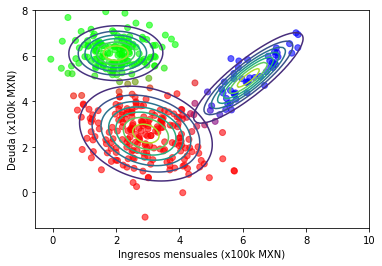

In [54]:
# Datos
plt.scatter(data["income"], data["debt"], 
            c=gmm.predict_proba(data[["income", "debt"]]),
            alpha=0.6)

# Gaussiana 1
x = np.linspace(0, 10, 100)
y = np.linspace(0, 8, 100)
x, y = np.meshgrid(x, y)
z = X1.pdf(np.dstack([x, y]))
plt.contour(x, y, z)

# Gaussiana 2
x = np.linspace(0, 10, 100)
y = np.linspace(0, 8, 100)
x, y = np.meshgrid(x, y)
z = X2.pdf(np.dstack([x, y]))
plt.contour(x, y, z)

# Gaussiana 3
x = np.linspace(0, 10, 100)
y = np.linspace(0, 8, 100)
x, y = np.meshgrid(x, y)
z = X3.pdf(np.dstack([x, y]))
plt.contour(x, y, z)

plt.xlabel("Ingresos mensuales (x100k MXN)")
plt.ylabel("Deuda (x100k MXN)")

In [55]:
def log_likelihood_gmm(X, mu, sigma, pi):
    """
    Log-likelihood of the data wrt Gaussian Mixture Model.
    :param data: Data.
    :param mu: Means of the components of the GMM.
    :param sigma: Covariances of the components of the GMM.
    :param pi: Weights of the components of the GMM.
    :return: Log-likelihood of the data wrt GMM.
    """
    # Number of clusters
    k = mu.shape[0]
    # Number of points
    N = X.shape[0]
    
    # Individual likelihood of each point to each normal
    ind_likelihood = np.zeros((N, k))
    for j in range(k):
        ind_likelihood[:, j] = multivariate_normal.pdf(X, mean=mu[j, :], cov=sigma[j, :, :])
    
    # Log likelihood
    log_likelihood = np.log(ind_likelihood.dot(pi)).mean()
        
    return log_likelihood

In [56]:
X_train, X_test = train_test_split(data[["income", "debt"]], test_size=0.2)

log_likelihood_train = []
log_likelihood_test = []
for k in range(2, 11):
    # Instanciamos el algoritmo
    gmm = GaussianMixture(n_components=k)
    
    # Entrenamos
    gmm.fit(X=X_train)
    pi = gmm.weights_
    mu = gmm.means_
    sigma = gmm.covariances_
    
    # Métrica con datos de entrenamiento
    log_likelihood_train.append(log_likelihood_gmm(X_train, mu, sigma, pi))
    
    # Métrica con datos de prueba
    log_likelihood_test.append(log_likelihood_gmm(X_test, mu, sigma, pi))

Text(0, 0.5, 'Log-verosimilitud')

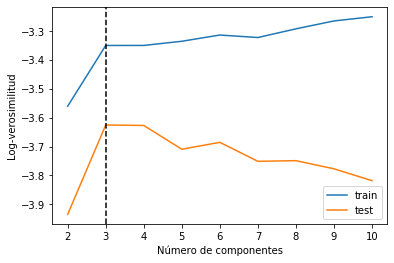

In [57]:
plt.plot(range(2, 11), log_likelihood_train, label="train")
plt.plot(range(2, 11), log_likelihood_test, label="test")
plt.axvline(x=3, ls="--", color="k")
plt.legend()
plt.xlabel("Número de componentes")
plt.ylabel("Log-verosimilitud")

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>